<a href="https://colab.research.google.com/github/FREDY129053/AI_Systems_LABS/blob/main/Lab_3_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Лаба 3.8: Кластеризация: алгоритмы K-means и EM

https://www.geeksforgeeks.org/machine-learning/k-means-clustering-introduction/

## Получение данных

In [1]:
!wget https://sci2s.ugr.es/keel/dataset/data/unsupervised/Quake.zip
!pip install patool

--2025-10-18 09:23:04--  https://sci2s.ugr.es/keel/dataset/data/unsupervised/Quake.zip
Resolving sci2s.ugr.es (sci2s.ugr.es)... 150.214.190.154
Connecting to sci2s.ugr.es (sci2s.ugr.es)|150.214.190.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17262 (17K) [application/zip]
Saving to: ‘Quake.zip’

Quake.zip           100%[===================>]  16.86K  --.-KB/s    in 0.1s    

2025-10-18 09:23:05 (117 KB/s) - ‘Quake.zip’ saved [17262/17262]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 2.9 MB/s eta 0:00:00


In [2]:
import patoolib

patoolib.extract_archive('/content/Quake.zip')

INFO patool: Extracting /content/Quake.zip ...
INFO:patool:Extracting /content/Quake.zip ...
INFO patool: running /usr/bin/7z x -aou -o/content/Unpack_4e6_p_6u -- /content/Quake.zip
INFO:patool:running /usr/bin/7z x -aou -o/content/Unpack_4e6_p_6u -- /content/Quake.zip
INFO patool: ... /content/Quake.zip extracted to `quake.dat'.
INFO:patool:... /content/Quake.zip extracted to `quake.dat'.


'quake.dat'

In [3]:
import pandas as pd

# Кастомный парсер, т.к. либы не могут прочитать файл из-за какой-то ошибки в строке 5-6
def read_arff_dat(path):
    with open(path, "r") as f:
        lines = f.readlines()

    data_start = 0
    attrs = []
    for i, ln in enumerate(lines):
        ln = ln.strip()
        if ln.lower().startswith("@attribute"):
            parts = ln.split()
            attrs.append(parts[1])
        if ln.lower().startswith("@data"):
            data_start = i + 1
            break

    data_lines = [ln.strip() for ln in lines[data_start:] if ln.strip() and not ln.startswith("%")]
    rows = []
    for ln in data_lines:
        parts = ln.split(",")
        row = []
        for p in parts:
            try:
                if "." in p:
                    row.append(float(p))
                else:
                    row.append(int(p))
            except ValueError:
                row.append(p)
        rows.append(row)

    df = pd.DataFrame(rows, columns=attrs)
    return df

df = read_arff_dat('quake.dat')
print(f"Размерность данных: {df.shape}")
df.head()

Размерность данных: (2178, 4)


,Focal_depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


## 1. Построить графики показателей (сумма квадратов расстояний, отношение среднего внутрикластерного расстояния к внекластерному) для различного количества кластеров для набора данных Quake. Определить оптимальное число кластеров, анализируя эмпирическую информацию распределения «очагов».

In [11]:
df_copy = df.copy()
start_clusters = 2
end_clusters = 25

### Определение оптимального кол-ва кластеров Kmeans

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

inertia = []
silhouettes = []

for k in range(start_clusters, end_clusters + 1):
    kmeans = KMeans(
      n_clusters=k,
      random_state=42,
      n_init='auto',
      max_iter=1_000_000,
      init="k-means++"
    )
    kmeans.fit(df_copy)
    inertia.append(kmeans.inertia_)

    labels_k = kmeans.fit_predict(df_copy)
    sil = silhouette_score(df_copy, labels_k)
    silhouettes.append(sil)

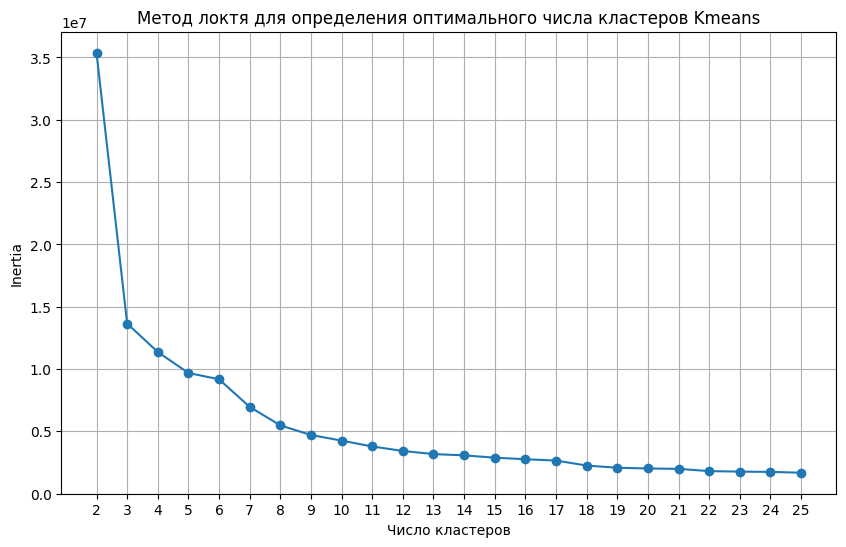

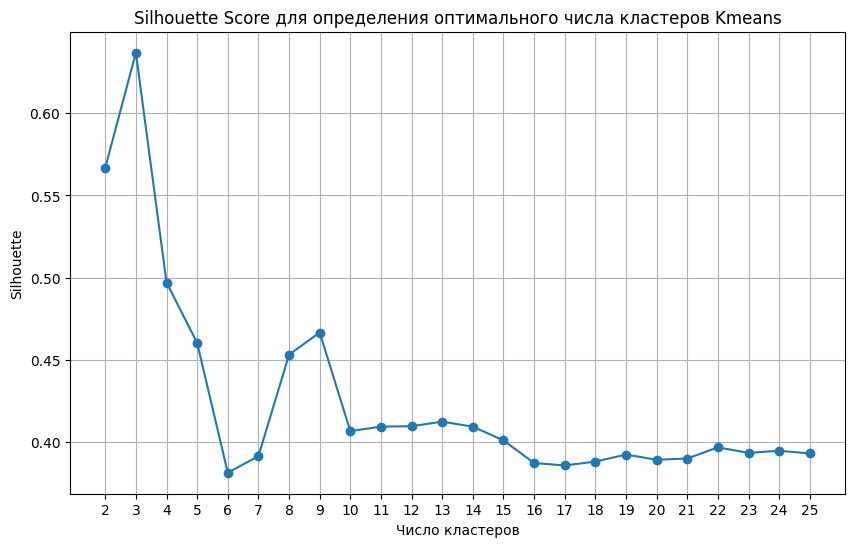

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(start_clusters, end_clusters + 1), inertia, marker='o')
plt.title("Метод локтя для определения оптимального числа кластеров Kmeans")
plt.xlabel("Число кластеров")
plt.ylabel("Inertia")
plt.xticks(range(start_clusters, end_clusters + 1))
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(start_clusters, end_clusters + 1), silhouettes, marker='o')
plt.title("Silhouette Score для определения оптимального числа кластеров Kmeans")
plt.xlabel("Число кластеров")
plt.ylabel("Silhouette")
plt.xticks(range(start_clusters, end_clusters + 1))
plt.grid(True)
plt.show()

По методу локтя видно, что оптимальное число кластеров 3 или 6
По silhouette score видно, что оптимальное число класеров 3 (максимальный score)

### Определение оптимального кол-ва кластеров EM

In [19]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import numpy as np

silhouettes = []

for k in range(start_clusters, end_clusters + 1):
    em = GaussianMixture(
      n_components=k,
      random_state=42,
      init_params='k-means++',
      max_iter=1_000_000
    )
    em.fit(df_copy)

    labels_k = em.predict(df_copy)
    sil = silhouette_score(df_copy, labels_k)
    silhouettes.append(sil)

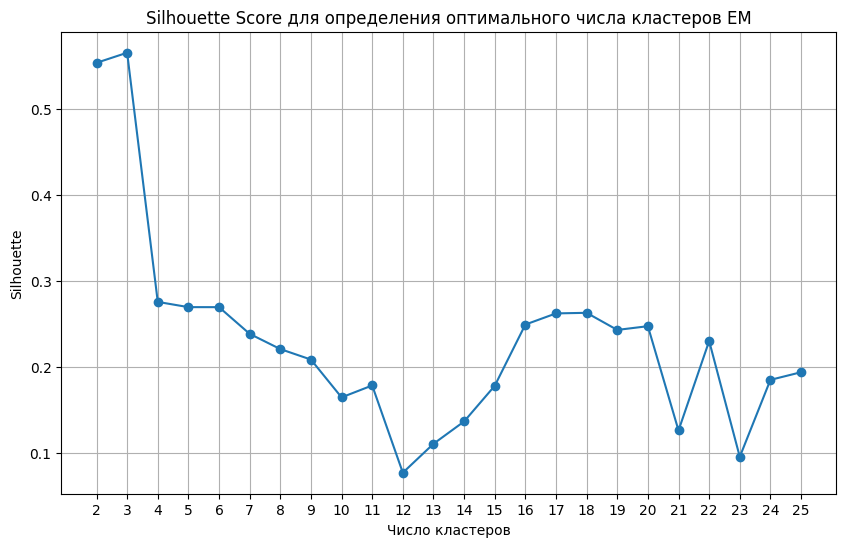

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(start_clusters, end_clusters + 1), silhouettes, marker='o')
plt.title("Silhouette Score для определения оптимального числа кластеров EM")
plt.xlabel("Число кластеров")
plt.ylabel("Silhouette")
plt.xticks(range(start_clusters, end_clusters + 1))
plt.grid(True)
plt.show()

По силуэт скору видно, что оптимальное число для EM алгоритма = 3

## Кластеризация датасета с оптимальным кол-вом кластеров для каждого алгоритма

### Kmeans

In [78]:
optimal_clusters_n = 3
df_kmeans = df.copy()

In [79]:
kmeans_optimal = KMeans(
  n_clusters=optimal_clusters_n,
  random_state=42,
  n_init='auto',
  max_iter=1_000_000,
  init="k-means++"
)
kmeans_optimal.fit(df_copy)

labels_kmeans = kmeans_optimal.fit_predict(df_copy)
centers_kmeans = kmeans_optimal.cluster_centers_

In [80]:
df_kmeans['Claster'] = labels_kmeans

In [91]:
df_kmeans['Claster'].value_counts()

,count
Claster,
0,1437
1,623
2,118


In [81]:
depth_and_richter = df_kmeans[['Focal_depth', 'Richter', 'Claster']]
lat_and_long = df_kmeans[['Latitude', 'Longitude', 'Claster']]

centers_depth_and_richter = [[i[0], i[-1]] for i in centers_kmeans]
centers_lat_and_long = [[i[1], i[2]] for i in centers_kmeans]

#### Визуализация кластеризации по глубине и очку Рихтера

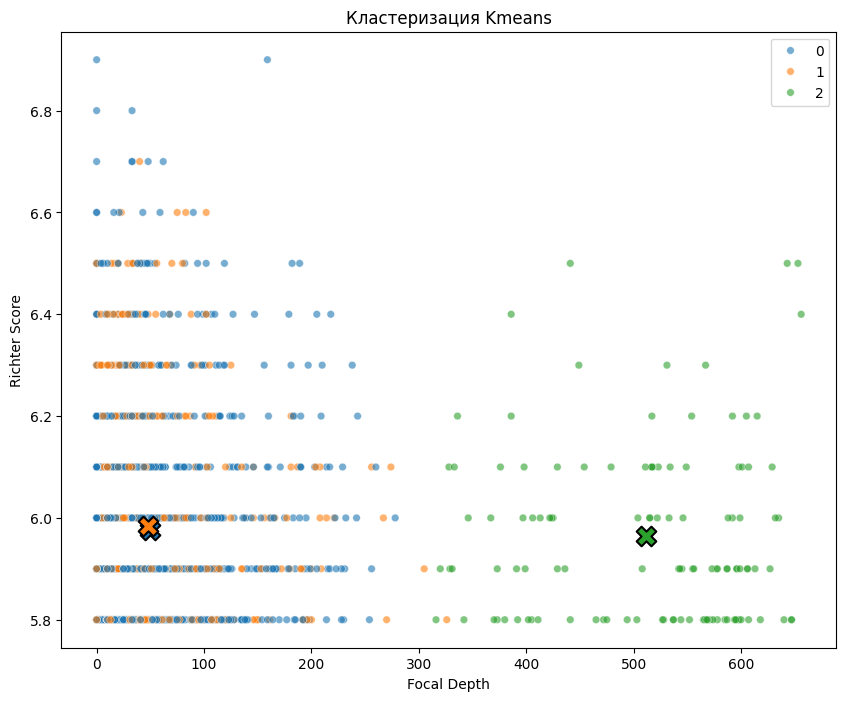

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", optimal_clusters_n)

sns.scatterplot(
    x = depth_and_richter.iloc[:, 0], y = depth_and_richter.iloc[:, 1],
    hue = labels_kmeans,
    palette = palette,
    legend = "full",
    alpha = 0.6,
    s = 30
)

for i in range(optimal_clusters_n):
  xi, yi = centers_depth_and_richter[i]
  color_i = palette[i]
  plt.scatter(xi, yi, color = color_i, marker = "X", s = 200, edgecolor = "k", linewidth = 1.5)

plt.title(f"Кластеризация Kmeans")
plt.xlabel("Focal Depth")
plt.ylabel("Richter Score")
plt.show()

#### Визуализация кластеризации по широте и долготе

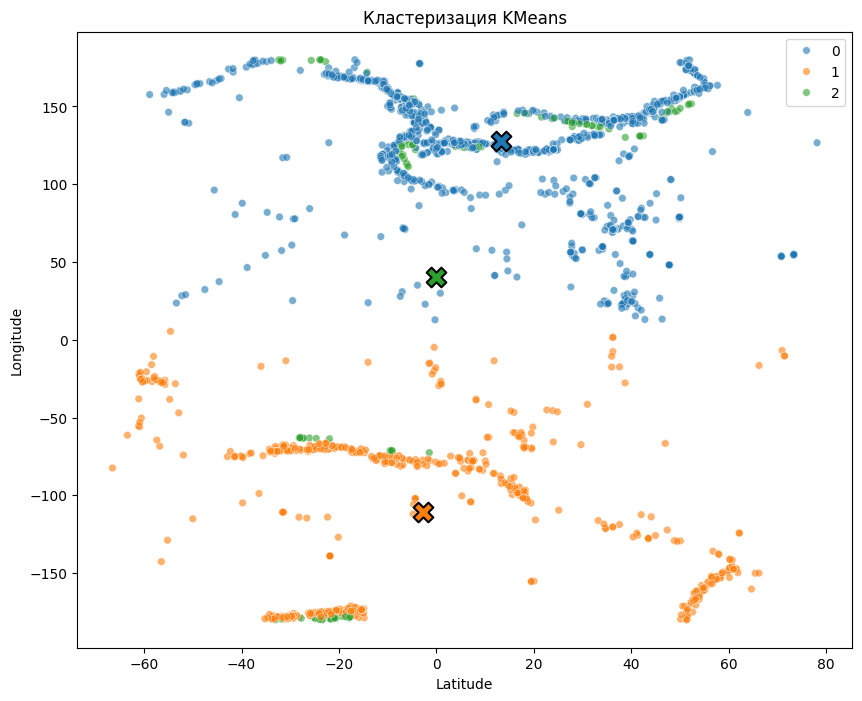

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", optimal_clusters_n)

sns.scatterplot(
    x = lat_and_long.iloc[:, 0], y = lat_and_long.iloc[:, 1],
    hue = labels_kmeans,
    palette = palette,
    legend = "full",
    alpha = 0.6,
    s = 30
)

for i in range(optimal_clusters_n):
  xi, yi = centers_lat_and_long[i]
  color_i = palette[i]
  plt.scatter(xi, yi, color = color_i, marker = "X", s = 200, edgecolor = "k", linewidth = 1.5)

plt.title(f"Кластеризация KMeans")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

#### Визуализаци по широте, долготе и очку Рихтера

In [93]:
import plotly.express as px
import pandas as pd
import numpy as np

df_plotly = df_kmeans[['Latitude', 'Longitude', 'Richter', 'Claster']].copy()

df_plotly['Claster'] = df_plotly['Claster'].astype(str)

fig = px.scatter_3d(
    df_plotly,
    x='Latitude',
    y='Longitude',
    z='Richter',
    color='Claster',
    title='3D Кластеризация K-means (Latitude, Longitude, Richter)',
    labels={'Latitude': 'Широта', 'Longitude': 'Долгота', 'Richter': 'Шкала Рихтера', 'Claster': 'Кластер'}
)

centers_3d_plotly = centers_kmeans[:, [1, 2, 3]]

fig.add_scatter3d(
    x=centers_3d_plotly[:, 0],
    y=centers_3d_plotly[:, 1],
    z=centers_3d_plotly[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='black',
        symbol='x'
    ),
    name='Cluster Centers'
)


fig.show()

### EM

In [94]:
optimal_clusters_n = 3
df_em = df.copy()

In [98]:
em_optimal = GaussianMixture(
  n_components=optimal_clusters_n,
  random_state=42,
  init_params='k-means++',
  max_iter=1_000_000
)
em_optimal.fit(df_em)

labels_em = em_optimal.fit_predict(df_em)
centers_em = em_optimal.means_

In [100]:
df_em['Claster'] = labels_em

In [101]:
df_em['Claster'].value_counts()

,count
Claster,
0,1293
1,604
2,281


In [102]:
depth_and_richter = df_em[['Focal_depth', 'Richter', 'Claster']]
lat_and_long = df_em[['Latitude', 'Longitude', 'Claster']]

centers_depth_and_richter = [[i[0], i[-1]] for i in centers_em]
centers_lat_and_long = [[i[1], i[2]] for i in centers_em]

#### Визуализация кластеризации по глубине и очку Рихтера

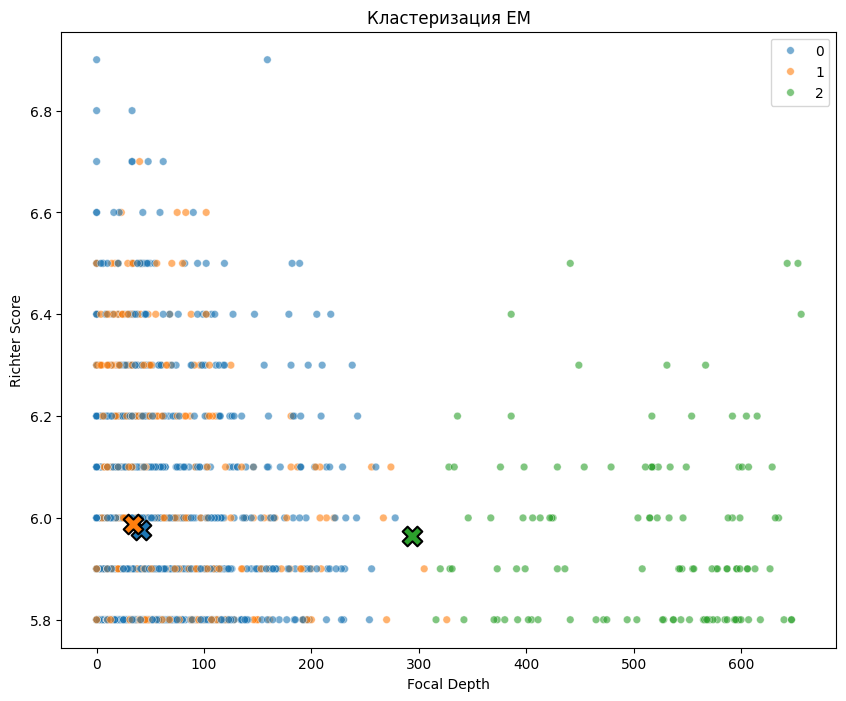

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", optimal_clusters_n)

sns.scatterplot(
    x = depth_and_richter.iloc[:, 0], y = depth_and_richter.iloc[:, 1],
    hue = labels_kmeans,
    palette = palette,
    legend = "full",
    alpha = 0.6,
    s = 30
)

for i in range(optimal_clusters_n):
  xi, yi = centers_depth_and_richter[i]
  color_i = palette[i]
  plt.scatter(xi, yi, color = color_i, marker = "X", s = 200, edgecolor = "k", linewidth = 1.5)

plt.title(f"Кластеризация EM")
plt.xlabel("Focal Depth")
plt.ylabel("Richter Score")
plt.show()

#### Визуализация кластеризации по широте и долготе

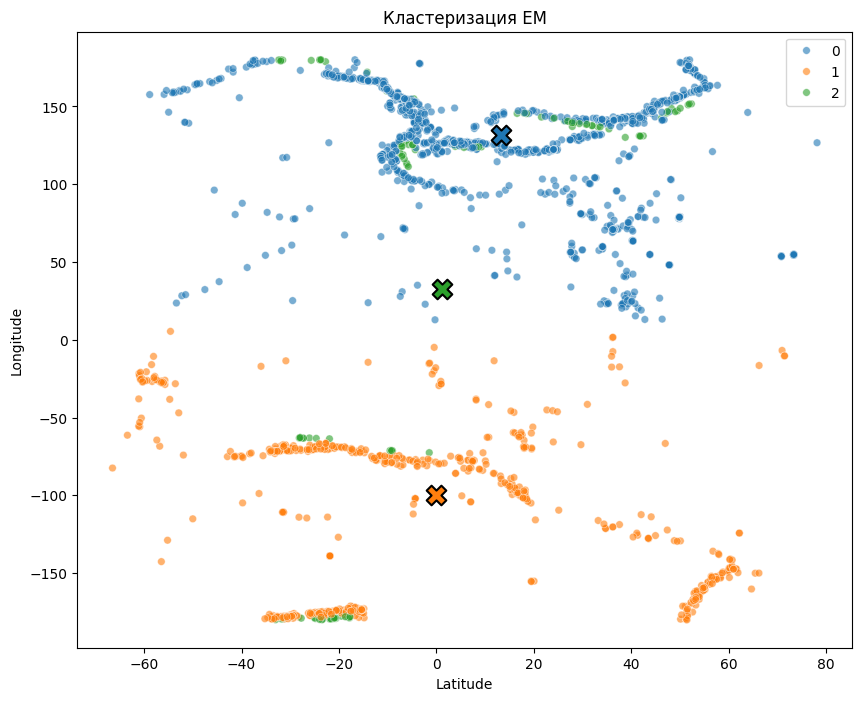

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", optimal_clusters_n)

sns.scatterplot(
    x = lat_and_long.iloc[:, 0], y = lat_and_long.iloc[:, 1],
    hue = labels_kmeans,
    palette = palette,
    legend = "full",
    alpha = 0.6,
    s = 30
)

for i in range(optimal_clusters_n):
  xi, yi = centers_lat_and_long[i]
  color_i = palette[i]
  plt.scatter(xi, yi, color = color_i, marker = "X", s = 200, edgecolor = "k", linewidth = 1.5)

plt.title(f"Кластеризация EM")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

#### Визуализаци по широте, долготе и очку Рихтера

In [106]:
import plotly.express as px
import pandas as pd
import numpy as np

df_plotly = df_kmeans[['Latitude', 'Longitude', 'Richter', 'Claster']].copy()

df_plotly['Claster'] = df_plotly['Claster'].astype(str)

fig = px.scatter_3d(
    df_plotly,
    x='Latitude',
    y='Longitude',
    z='Richter',
    color='Claster',
    title='3D Кластеризация K-means (Latitude, Longitude, Richter)',
    labels={'Latitude': 'Широта', 'Longitude': 'Долгота', 'Richter': 'Шкала Рихтера', 'Claster': 'Кластер'}
)

centers_3d_plotly = centers_kmeans[:, [1, 2, 3]]

fig.add_scatter3d(
    x=centers_3d_plotly[:, 0],
    y=centers_3d_plotly[:, 1],
    z=centers_3d_plotly[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='black',
        symbol='x'
    ),
    name='Cluster Centers'
)


fig.show()

## Сравнение предсказанных центров обоих алгоритмов

In [108]:
from prettytable import PrettyTable

table = PrettyTable()
table.title = "Сравнение рассчитанных центров Kmeans VS EM"
table.field_names = ["№ кластера", "Разница Focal_depth", "Разница Latitude", "Разница Longtitude", "Разница Richter"]

kmeans = centers_kmeans
em = centers_em

for i in range(len(kmeans)):
  kmeans_center_i = kmeans[i]
  em_center_i = em[i]
  row = []
  row.append(f"Кластер {i+1}")
  row.append(f"{abs(kmeans_center_i[0] - em_center_i[0]):.5f}")
  row.append(f"{abs(kmeans_center_i[1] - em_center_i[1]):.5f}")
  row.append(f"{abs(kmeans_center_i[2] - em_center_i[2]):.5f}")
  row.append(f"{abs(kmeans_center_i[3] - em_center_i[3]):.5f}")
  table.add_row(row)

print(table)

+--------------------------------------------------------------------------------------------+
|                        Сравнение рассчитанных центров Kmeans VS EM                         |
+------------+---------------------+------------------+--------------------+-----------------+
| № кластера | Разница Focal_depth | Разница Latitude | Разница Longtitude | Разница Richter |
+------------+---------------------+------------------+--------------------+-----------------+
| Кластер 1  |       8.62945       |     0.04911      |      4.03314       |     0.00011     |
| Кластер 2  |       14.47450      |     2.62172      |      10.84244      |     0.00381     |
| Кластер 3  |      218.16572      |     1.25043      |      7.71126       |     0.00036     |
+------------+---------------------+------------------+--------------------+-----------------+
